In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import cv2 as cv
import numpy as np
import pandas as pd
import os
from tensorflow.keras.utils import to_categorical
from glob import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
df = pd.read_csv('../input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')

In [3]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [4]:
df.dtypes

lesion_id        object
image_id         object
dx               object
dx_type          object
age             float64
sex              object
localization     object
dtype: object

In [5]:
df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

### 1.2- data cleaning

In [6]:
df['age'].fillna(int(df['age'].mean()),inplace=True)

### 1.3- data preprocessing

In [7]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [8]:
base_skin_dir = '../input/skin-cancer-mnist-ham10000'
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

In [9]:
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get) 

In [10]:
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes
df.head(2)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2


In [11]:
from keras.preprocessing.image import img_to_array, array_to_img
df['image'] = df['path'].map(lambda x: img_to_array(cv.resize(cv.imread(x),(100,100),interpolation = cv.INTER_AREA)))

In [12]:
df.columns

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization',
       'path', 'cell_type', 'cell_type_idx', 'image'],
      dtype='object')

<AxesSubplot:>

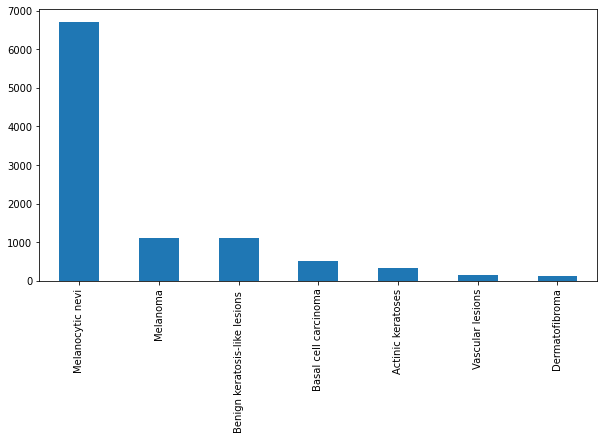

In [13]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

In [14]:
df2=df[["image","cell_type_idx"]]

In [15]:
X=df2["image"]
Y=df2["cell_type_idx"]

In [16]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 0) 

In [17]:
x_train = np.asarray(x_train.tolist())
x_test = np.asarray(x_test.tolist())

In [18]:
y_train = to_categorical(y_train, num_classes = 7)
y_test = to_categorical(y_test, num_classes = 7)

In [19]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

# VIT MODEL

In [20]:
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow_addons as tfa
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report

In [21]:
learning_rate = 0.001
weight_decay = 0.0001
num_epochs = 1
image_size=100
patch_size = 7  # Size of the patches to be extract from the input images
num_patches = (100 // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [56, 28]  # Size of the dense layers of the final classifier

In [22]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = L.Dense(units, activation = tf.nn.gelu)(x)
        x = L.Dropout(dropout_rate)(x)
    return x

In [23]:
class Patches(L.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes = [1, self.patch_size, self.patch_size, 1],
            strides = [1, self.patch_size, self.patch_size, 1],
            rates = [1, 1, 1, 1],
            padding = 'VALID',
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [24]:
class PatchEncoder(L.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = L.Dense(units = projection_dim)
        self.position_embedding = L.Embedding(
            input_dim = num_patches, output_dim = projection_dim
        )

    def call(self, patch):
        positions = tf.range(start = 0, limit = self.num_patches, delta = 1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [25]:
def vision_transformer():
    inputs = L.Input(shape = (image_size, image_size, 3))
    
    # Create patches.
    patches = Patches(patch_size)(inputs)
    
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        
        # Layer normalization 1.
        x1 = L.LayerNormalization(epsilon = 1e-6)(encoded_patches)
        
        # Create a multi-head attention layer.
        attention_output = L.MultiHeadAttention(
            num_heads = num_heads, key_dim = projection_dim, dropout = 0.1
        )(x1, x1)
        
        # Skip connection 1.
        x2 = L.Add()([attention_output, encoded_patches])
        x3 = L.LayerNormalization(epsilon = 1e-6)(x2)
        
        # MLP.
        x3 = mlp(x3, hidden_units = transformer_units, dropout_rate = 0.1)
        
        # Skip connection 2.
        encoded_patches = L.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = L.LayerNormalization(epsilon = 1e-6)(encoded_patches)
    representation = L.Flatten()(representation)
    representation = L.Dropout(0.5)(representation)
    
    # Add MLP.
    features = mlp(representation, hidden_units = mlp_head_units, dropout_rate = 0.5)
    
    # Classify outputs.
    logits = L.Dense(7)(features)
    
    # Create the model.
    model = tf.keras.Model(inputs = inputs, outputs = logits)
    
    return model

In [26]:
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=10,
        zoom_range = 0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=False,
        vertical_flip=False)

In [27]:
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

In [28]:
model = vision_transformer()
    
model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.1), 
              metrics = ['accuracy'])

In [29]:
epochs = 50 
history = model.fit(datagen.flow(x_train,y_train, batch_size=32),
                              epochs = epochs, validation_data = (x_validate,y_validate)
                              )

Epoch 1/50
226/226 [==============================] - 32s 93ms/step - loss: 5.4904 - accuracy: 0.2380 - val_loss: 11.3124 - val_accuracy: 0.6633
Epoch 2/50
226/226 [==============================] - 20s 86ms/step - loss: 5.9912 - accuracy: 0.1025 - val_loss: 1.7962 - val_accuracy: 0.0125
Epoch 3/50
226/226 [==============================] - 20s 86ms/step - loss: 5.9103 - accuracy: 0.1180 - val_loss: 3.5799 - val_accuracy: 0.0125
Epoch 4/50
226/226 [==============================] - 20s 87ms/step - loss: 6.2143 - accuracy: 0.1402 - val_loss: 13.0794 - val_accuracy: 0.1209
Epoch 5/50
226/226 [==============================] - 20s 87ms/step - loss: 4.9061 - accuracy: 0.1287 - val_loss: 3.5797 - val_accuracy: 0.0100
Epoch 6/50
226/226 [==============================] - 20s 87ms/step - loss: 4.3193 - accuracy: 0.1252 - val_loss: 1.4192 - val_accuracy: 0.0100
Epoch 7/50
226/226 [==============================] - 20s 86ms/step - loss: 5.4562 - accuracy: 0.1122 - val_loss: 0.7861 - val_accurac

# MobileNet


In [30]:
MobileNetModel = tf.keras.applications.MobileNetV2(
    input_shape=(100, 100, 3),
     include_top=False, 
     weights='imagenet',
     pooling='avg'
)
MobileNetModel.trainable = False

inputs = MobileNetModel.input

x = tf.keras.layers.Dense(512, activation='relu')(MobileNetModel.output)
x = tf.keras.layers.Dense(512, activation='relu')(x)

outputs = tf.keras.layers.Dense(7, activation='softmax')(x)

model_1 = tf.keras.Model(inputs=inputs, outputs=outputs)

9420800/9406464 [==============================] - 0s 0us/step


In [31]:
# Initialize ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    preprocessing_function=tf.keras.applications.mobilenet.preprocess_input
)

# Compile the model
model_1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Create data generators for training and validation data
x_train_gen = train_datagen.flow(x_train, y_train, batch_size=16)
val_data = train_datagen.flow(x_validate, y_validate, batch_size=16)

In [32]:
# Train the model and store the training history
history_1 = model_1.fit(
    x_train_gen,
    epochs=25,
    validation_data=val_data,
    batch_size=32  # Batch size should match the batch size in the data generator
)

Epoch 1/25
451/451 [==============================] - 14s 14ms/step - loss: 0.8746 - accuracy: 0.7065 - val_loss: 0.7685 - val_accuracy: 0.7244
Epoch 2/25
451/451 [==============================] - 5s 12ms/step - loss: 0.7110 - accuracy: 0.7420 - val_loss: 0.7832 - val_accuracy: 0.7294
Epoch 3/25
451/451 [==============================] - 5s 12ms/step - loss: 0.6370 - accuracy: 0.7664 - val_loss: 0.8014 - val_accuracy: 0.7232
Epoch 4/25
451/451 [==============================] - 5s 12ms/step - loss: 0.5829 - accuracy: 0.7871 - val_loss: 0.7692 - val_accuracy: 0.7232
Epoch 5/25
451/451 [==============================] - 6s 13ms/step - loss: 0.5298 - accuracy: 0.7999 - val_loss: 0.8242 - val_accuracy: 0.7219
Epoch 6/25
451/451 [==============================] - 5s 12ms/step - loss: 0.4869 - accuracy: 0.8209 - val_loss: 0.8335 - val_accuracy: 0.7357
Epoch 7/25
451/451 [==============================] - 5s 12ms/step - loss: 0.4428 - accuracy: 0.8350 - val_loss: 0.8483 - val_accuracy: 0.728

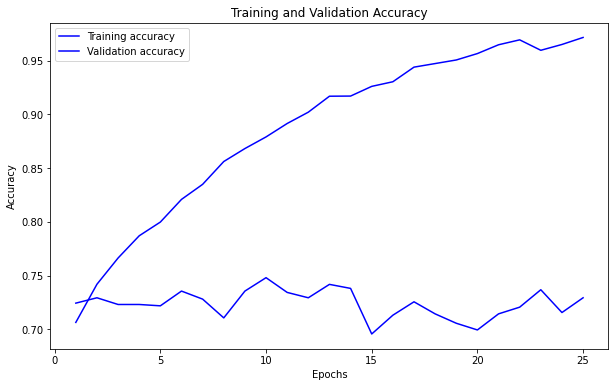

In [33]:
# Plot training and validation accuracy
train_accuracy = history_1.history['accuracy']
val_accuracy = history_1.history['val_accuracy']
epochs = range(1, len(train_accuracy) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()